# Part 2: Guided Diffusion (with CLIP)

In this part of the assignment you will experiment with a **text-to-image model** implemented with **guided diffusion** from the **stable diffusion** family of open-source guided latent diffusion models.

## Learning Objectives
You will:
1. Use a **CLIP** model contrastively trained in text and image (you will use the text and image encoder) to conduct similarity searching between text and images in the learned embedding space.
2. Condition a pretrained stable diffusion model on CLIP text embeddings
3. Implement guidance for the stable diffusion model, combining text-conditioned and non-text-conditioned noise predictions for inference

Note: This assignment is intended to utilize GPU resources such as `CUDA` through the CS department cluster, Google colab (or local GPU resources for those running on machines with GPU support). The **code below assumes CUDA**; you will need to modify it if working with the [`mps` backend](https://docs.pytorch.org/docs/stable/notes/mps.html).

## Task 1

In this part, implement and qualitatively evaluate similarity searching with CLIP on the Pokemon sprites dataset (effectively implementing text-to-image search functionality).

We begin with the following three cells for you to run to (your todos follow afterwards):
1. Download the dataset,
2. Download CLIP, and
3. Precompute CLIP embeddings of all images in the dataset

Dataset already exists: 129 images


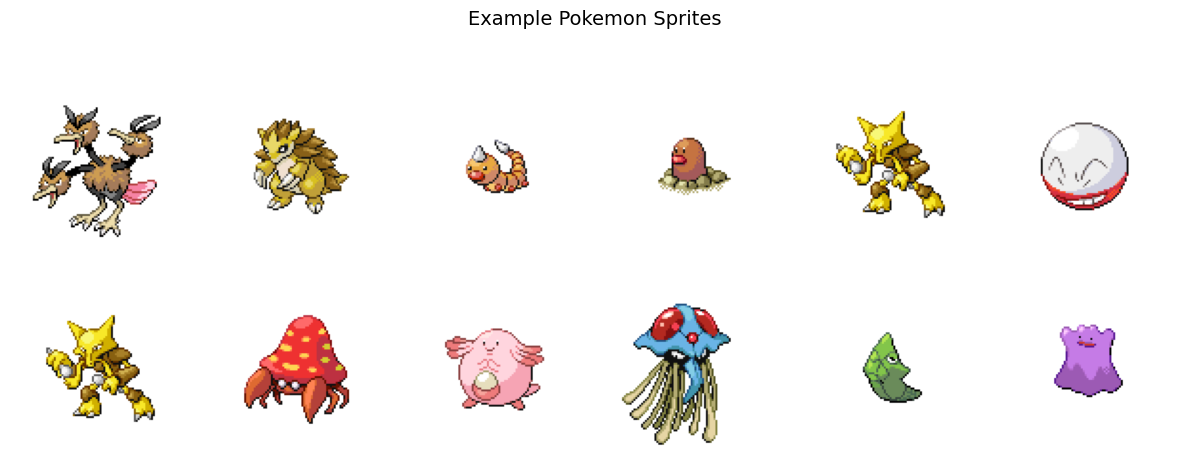

In [1]:
# DOWNLOAD AND PREVIEW DATASET OF POKEMON SPRITES
# This is boilerplate and you do not need to review it carefully

from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import urllib.request
import zipfile

DATASET_URL = "https://duke.box.com/shared/static/qkrbjqh2k1ie5e606tzbvxbi85ks3px0.zip"
DATASET_DIR = "pokemon_deduplicated"

# Check if already downloaded
if Path(DATASET_DIR).exists() and len(list(Path(DATASET_DIR).glob('*.png'))) > 100:
    print(f"Dataset already exists: {len(list(Path(DATASET_DIR).glob('*.png')))} images")
else:
    print("Downloading Pokemon sprites dataset...")
    urllib.request.urlretrieve(DATASET_URL, "dataset.zip")

    print("Extracting...")
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall('.')

    # Cleanup
    Path("dataset.zip").unlink()

    # Verify
    num_images = len(list(Path(DATASET_DIR).glob('*.png')))
    if num_images > 100:
        print(f"Success! {num_images} images ready")
    else:
        print(f"Warning: Only found {num_images} images (expected >100)")

pokemon_images = [Image.open(img_path).convert('RGB') for img_path in Path(DATASET_DIR).glob('*.png')]

def show_images_grid(images, titles=None, rows=2, cols=6, figsize=(12, 5), suptitle=None):
    """
    Helper function to display a grid of images.

    Args:
        images: List of PIL Images or numpy arrays
        titles: Optional list of titles for each image
        rows, cols: Grid dimensions
        figsize: Figure size
        suptitle: Optional overall title
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for idx, ax in enumerate(axes):
        if idx < len(images):
            ax.imshow(images[idx])
            if titles and idx < len(titles):
                ax.set_title(titles[idx], fontsize=10)
        ax.axis('off')

    if suptitle:
        plt.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()

sample_images = [pokemon_images[np.random.randint(0, len(pokemon_images))] for _ in range(12)]
show_images_grid(sample_images, suptitle="Example Pokemon Sprites")

In [2]:
# PRECOMPUTE DENSE EMBEDDINGS USING CLIP
# This computes dense embeddings of all of the Pokemon images using CLIP
# You should review this code -- observe how CLIP has a processor for
# preparing the inputs, as well as a get_image_features method for
# retrieving the embeddings. The results resulting image_embeddings have a
# row for every image and uses an embedding dimension of 512

import torch
from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", weights_only=False).to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

inputs = clip_processor(images=pokemon_images, return_tensors="pt").to(device)

with torch.no_grad():
    image_embeddings = clip_model.get_image_features(**inputs)

    # Normalizing vectors
    image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

print(f"Pre-computed embeddings: {image_embeddings.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Pre-computed embeddings: torch.Size([129, 512])


**TODOS** In this task, you'll implement text-to-image similarity search using CLIP's learned embedding space.

**Your goal:** Implement the `find_most_similar_image()` function to find the Pokemon sprite most similar to a text query, then test your implementation using the provided `test_similarity_search()` function.

**Implementation Details:**
1. Encode the text query using CLIP's text encoder
2. Normalize the text embedding (divide by its L2 norm)
3. Compute similarities between text embedding and all pre-computed image embeddings
4. Find the index of the highest similarity
5. Return the corresponding image and similarity score
6. Test using the provided `test_similarity_search()` function below

**Helpful documentation:**
- [`model.get_text_features()`](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel.get_text_features) - Encode text with CLIP
- [`torch.matmul()`](https://pytorch.org/docs/stable/generated/torch.matmul.html) - Compute dot products for similarity
- [`torch.argmax()`](https://pytorch.org/docs/stable/generated/torch.argmax.html) - Find index of maximum value

**Expected results:** When working correctly, you should see results that make intuitive qualitative sense given the query description. The similarity scores of the top matches (at least for the default queries) should be > 0.25. Feel free to play with different testing queries, but make sure that you leave at least four results that make intuitive qualitative sense and achieve high similarity scores for your final submission.

In [3]:
def find_most_similar_image(text_query, image_embeddings, images, model, processor, device):
    """
    Find the image most similar to a text query using CLIP.

    Args:
        text_query: Text description (string)
        image_embeddings: Pre-computed CLIP image embeddings (N, 512)
        images: List of N PIL Images
        model: CLIP model
        processor: CLIP processor
        device: torch device

    Returns:
        most_similar_image: The PIL Image most similar to the query
        similarity_score: The similarity score (float)
    """
    # TODO: Implement find_most_similar_image
    task1_input = processor(text = [text_query], return_tensors = "pt").to(device)
    with torch.no_grad():
      text_embedding = model.get_text_features(**task1_input)
    text_embedding = text_embedding / text_embedding.norm(dim = 1)
    similarities = torch.matmul(text_embedding, image_embeddings.T)
    highest_similarity_index = torch.argmax(similarities, dim = 1).item()
    most_similar_image = images[highest_similarity_index]
    similarity_score = similarities[0, highest_similarity_index].item()
    return most_similar_image, similarity_score

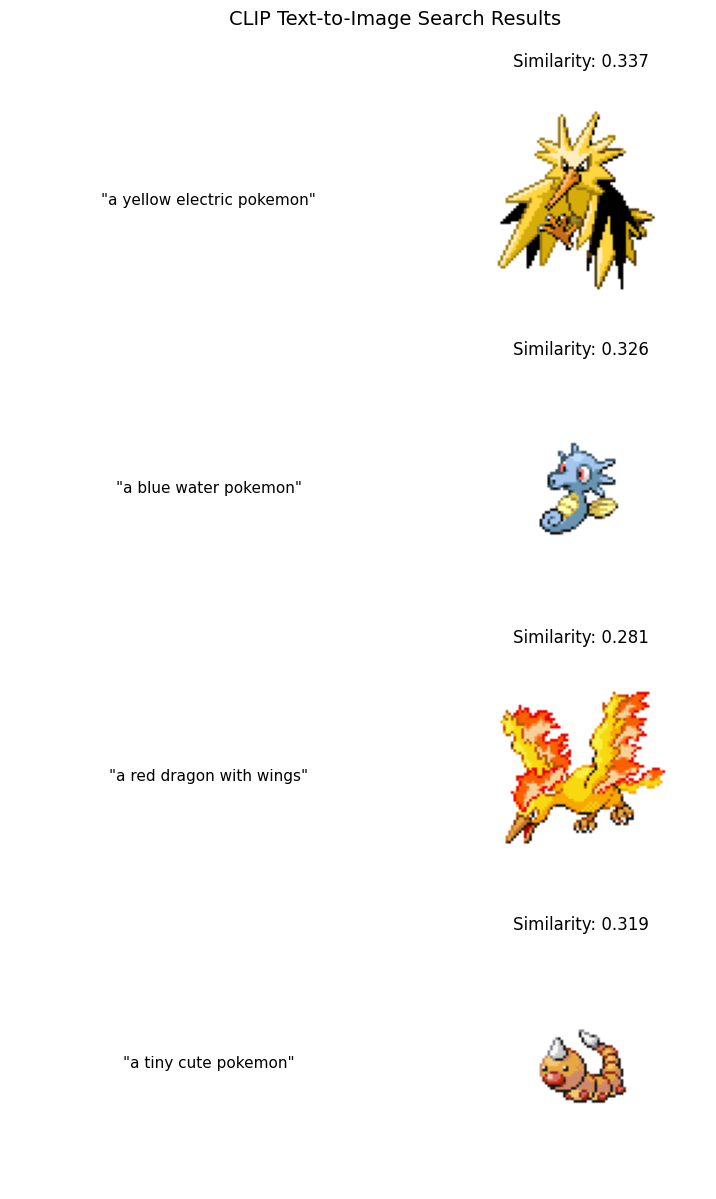

In [4]:
def test_similarity_search(test_queries):
    """Run test queries and visualize results."""
    results = []
    for query in test_queries:
        result_image, score = find_most_similar_image(
            query, image_embeddings, pokemon_images,
            clip_model, clip_processor, device
        )
        results.append((query, result_image, score))

    fig, axes = plt.subplots(len(test_queries), 2, figsize=(8, 3*len(test_queries)))
    for i, (query, img, score) in enumerate(results):
        axes[i, 0].text(0.5, 0.5, f'"{query}"', ha='center', va='center', fontsize=11, wrap=True)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f'Similarity: {score:.3f}', fontsize=12)
        axes[i, 1].axis('off')
    plt.suptitle("CLIP Text-to-Image Search Results", fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()


# Run tests
queries = ["a yellow electric pokemon", "a blue water pokemon", "a red dragon with wings", "a tiny cute pokemon"]
test_similarity_search(queries)

## Task 2: Exploring Guidance Scale

For the rest of this assignment you will be working with a **pretrained open-source Stable Diffusion model for text-to-image generation**.

In this preliminary task, you will experiment with a complete `StableDiffusionPipeline` that abstracts the implementation entirely. You will experiment with the **guidance scale** parameter to understand its effect on generation quality.

**TODOS**
1. Run the provided code that generates images at different guidance scales
2. Observe the results and answer the reflection questions that follow.

**NOTES**: This task requires the diffusers library and its dependencies. You should install them first. Like: `!pip install diffusers`

**Hints:**
- You may encounter missing library errors, so you'll need to install all the missing dependencies.
- You might also face version compatibility issues, which generally require reinstalling libraries to consistent versions.

In [5]:
# DOWNLOAD STABLE DIFFUSION MODEL
# Observe that the stable diffusion pipeline consists of the UNet, the
# text_encoder, and the variational autoencoder (VAE).

from diffusers import StableDiffusionPipeline
import torch

# Load a tiny Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")

# Get parameters from all main components
unet_params = sum(p.numel() for p in pipe.unet.parameters())
text_encoder_params = sum(p.numel() for p in pipe.text_encoder.parameters())
vae_params = sum(p.numel() for p in pipe.vae.parameters())

total_params = unet_params + text_encoder_params + vae_params

print(f"UNet parameters: {unet_params:,}")
print(f"Text Encoder parameters: {text_encoder_params:,}")
print(f"VAE parameters: {vae_params:,}")
print(f"Total parameters: {total_params:,}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

UNet parameters: 859,520,964
Text Encoder parameters: 123,060,480
VAE parameters: 83,653,863
Total parameters: 1,066,235,307


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

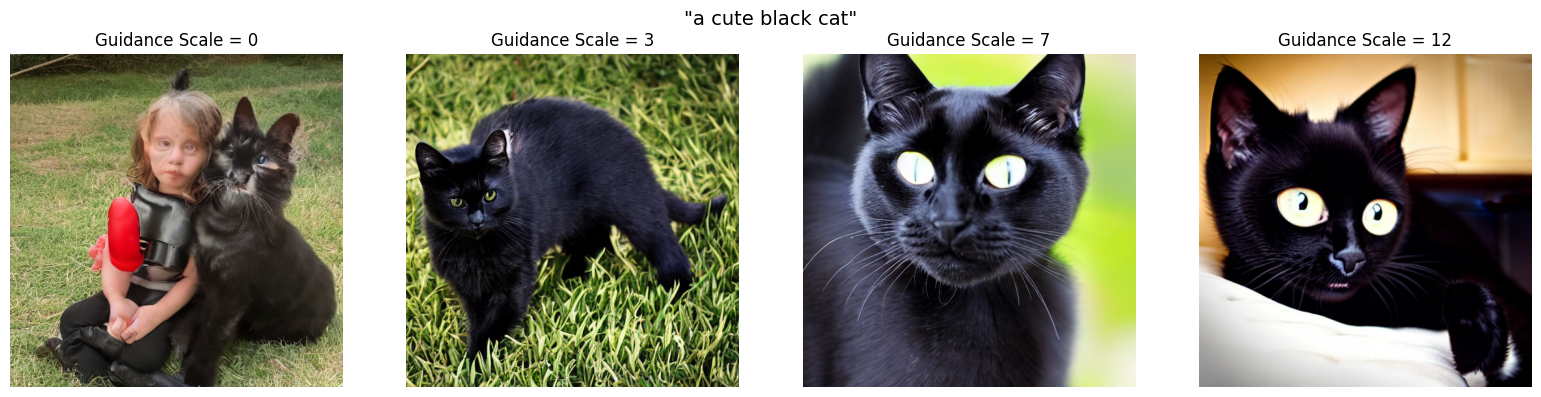

In [6]:
# Generate images at different guidance scales
prompt = "a cute black cat"

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, guidance_scale in enumerate([0, 3, 7, 12]):
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
    axes[idx].imshow(image)
    axes[idx].set_title(f'Guidance Scale = {guidance_scale}')
    axes[idx].axis('off')

plt.suptitle(f'"{prompt}"', fontsize=14)
plt.tight_layout()
plt.show()

**TODO: Answer reflection questions:**

1. Compare the extreme cases of guidance scale (0 and 12) qualitatively. What happens when the guidance scale is very small? What about when it is very large? Describe in 2-5 sentences of plain English commentary.

**Answer 1 (TODO):** From what I see from the results, an observation I found is that the model mostly ignores the text prompt and would produce random or unrelated images whenever the guidance scale is very small. Like with the image where the guidance scale is 0, I can see that the model does not follow the prompt of producing an image of a cute black cat as there is a cat with some cat-like features in the image, but the cat's face does not really look like a cat and also the model generated a little child beside the cat even if I did not ask for it in the text prompt. On the other hand, the model the model tend to become too focused on the text prompt which would make the model to produce overly perfect or rigid images that looks less natural when the guidance scale is very large. Like with the image that has the guidance scale of 12, the model is able to follow the prompt of producing an image of a cute black cat, but the image does look unnatural with the extra added details of the cat such as the high contrast black fur and the bright green eyes that make the cat seem unrealistic compared to the cat images with the guidance scale of 3 and 7.


2. How is the guidance implemented mathematically in the model's generation? How does that explain the difference in generations at guidance scales 0 and 12 that you described in question 1? Provide the mathematical definition then explain in 2-5 sentences.

**Answer 2 (TODO):** Well the guidance formula would be guided_noise = noise_uncond + guidance_scale X (noise_cond - noise_uncond). Now when the guidance scale is 0, the second term of the formula disappears which would mean that the model would ignore the text prompt and would generate random images. But when the gradiance scale gets bigger, then the model would give more weight to the difference between the conditional and unconditional noise predictions. With this, the model would focus more on the text prompt and would generate images that would be closely based on the description. However, if the guidance scale is too high such as 12 for this instance, then the image that is produced would look unnatural or strange since the model overemphasizes the text prompt.


3. Why are guidance scales like 7 or 8 the most common defaults for many applications? For what kind of applications might a smaller or larger value be appropriate?.

**Answer 3 (TODO):** I say that the guidance scales like 7 or 8 are the most common since they do balance the image quality and how well the image matches the text prompt. So the model is able to produce images that are realisitic and relevant to the text description when the guidance scales are at those ranges. There are some applications were it is appropriate to use smaller or larger guidance scales. For smaller scales, it can be useful to produce images that are more creative or more varied since the model would follow the text prompt less strictly. And for larger scales, it can be useful whenever we want to produce images that matches the text prompt very closely even if the image would look less natural.


## Task 3: Implementing Guided Diffusion from Scratch

In this previous task, you used the `StableDiffusionPipeline` API that abstracts the implementation entirely.

In this task, you will still use the pretrained Stable Diffusion model, but you will provide your implementation of **classifier-free guidance**. You will extract the components of the Stable Diffusion model from the pipeline (the CLIP tokenizer and encoder, the variational autoencoder, and the UNet) and combine them together for your own implementation of generation.

Recall that classifier-free guidance trades off two predictions to strengthen text conditioning. At every step of the generative (reverse diffusion) process, the UNet makes two predictions, one with text-conditioning, and one without it (which Stable Diffusion implements using the empty string `""` as a reserved placeholder for no conditioning). These are combined to form an overall guided prediction.

**Implementation Details:**

Your task is to complete the `sample_with_guidance()` function below. Most of the boilerplate is provided, but you need to implement the core guidance logic in the denoising loop (marked with `#TODO`). You will need to work with the individual components:

- **UNet** (`pipe.unet`): Predicts noise given current latents, timestep, and text embeddings
- **Scheduler** (`pipe.scheduler`): Manages the denoising schedule and removes predicted noise
- **Text Encoder** (`pipe.text_encoder`): Converts text to embeddings that condition the UNet
- **Tokenizer** (`pipe.tokenizer`): Converts text strings to tokens for the text encoder
- **VAE** (`pipe.vae`): Decodes latents from 64×64 latent space to 512×512 pixel space

Inside the denoising loop (marked with `# TODO`), you need to:

1. **Get noise predictions**: Call the UNet to predict noise for both the conditional (with text) and unconditional (empty text) cases
   - Call the UNet as: `noise_pred = unet(latents, timestep, encoder_hidden_states=text_embeddings).sample`
   - The `.sample` attribute extracts the noise prediction tensor from the returned object
   - You need to do this twice: once with `uncond_embeddings` and once with `text_embeddings`

2. **Apply classifier-free guidance**: Combine the two noise predictions using the guidance formula:
```
   guided_noise = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
```

3. **Update latents**: Use the scheduler to remove the guided noise prediction from the current latents
   - Call: `updated_latents = scheduler.step(noise_pred, timestep, latents).prev_sample`
   - The `.prev_sample` attribute extracts the denoised latents tensor from the returned object

**Important technical details:**
- Latent space is 64×64 for 512×512 images (8× downsampling by VAE)
- Latents have 4 channels (not 3 like RGB images)
- The scaling factor `0.18215` is specific to Stable Diffusion's VAE training
- Text embeddings have shape `(1, 77, 768)` - 77 token positions, 768-dimensional

**Helpful documentation:**
- [UNet2DConditionModel.forward()](https://huggingface.co/docs/diffusers/v0.21.0/en/api/models/unet2d-cond#diffusers.UNet2DConditionModel.forward)
- [DDPMScheduler.step()](https://huggingface.co/docs/diffusers/v0.21.0/en/api/schedulers/ddpm#diffusers.DDPMScheduler.step) -
- [DDPMScheduler.scale_model_input()](https://huggingface.co/docs/diffusers/v0.21.0/en/api/schedulers/ddpm#diffusers.DDPMScheduler.scale_model_input)


**Test your implementation:**
Run the code cell after the implementation to test. The code will attempt to generate images using the same text prompt and guidance scales as in the previous Task 2 with the `StableDiffusionPipeline`. With a correct implementation, you should see results that are qualitatively consistent with those generated in Task 2 (though not exactly the same, given that the generations use different random seeds).

**Answer the reflection questions** that follow after testing.

In [7]:
def sample_with_guidance(pipe, prompt, num_steps=50, guidance_scale=7, image_size=512, device="cuda"):
    """
    Generate an image from a text prompt using classifier-free guidance.

    Args:
        pipe: Pretrained StableDiffusionPipeline containing unet, scheduler,
              text_encoder, tokenizer, and vae components
        prompt: Text description (string)
        num_steps: Number of denoising steps
        guidance_scale: Strength of text conditioning (higher = stronger)
        image_size: Output image size (512 for SD 1.5)
        device: "cuda" or "cpu"

    Returns:
        Generated image tensor (1, 3, H, W) in range [-1, 1]
    """
    # Extract components from pipeline
    unet = pipe.unet
    scheduler = pipe.scheduler
    text_encoder = pipe.text_encoder
    tokenizer = pipe.tokenizer
    vae = pipe.vae

    # Tokenize and encode text prompt and empty string (for unconditional generation)
    max_length = tokenizer.model_max_length
    text_input = tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True,return_tensors="pt")
    uncond_input = tokenizer("", padding="max_length", max_length=max_length, truncation=True,return_tensors="pt")

    # Compute text embeddings for both conditional and unconditional
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Initialize random latents in latent space (64×64 for 512×512 images)
    latent_size = image_size // 8  # VAE downsamples by factor of 8
    latents = torch.randn(1, 4, latent_size, latent_size).to(device)
    latents = latents * scheduler.init_noise_sigma

    # Set up the scheduler with the desired number of timesteps
    scheduler.set_timesteps(num_steps)

    # Denoising loop
    for t in scheduler.timesteps:
        # Prepare input (some schedulers require this scaling)
        latent_model_input = scheduler.scale_model_input(latents, t)
        with torch.no_grad():
            # TODO: Implement classifier-free guidance
            # Get noise predictions for both conditions:
            # 1. Get unconditional noise prediction using uncond_embeddings
            # 2. Get conditional noise prediction using text_embeddings
            # 3. Combine them using the guidance formula:
            #    guided_noise = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
            noise_uncond = unet(latent_model_input, t, encoder_hidden_states = uncond_embeddings).sample
            noise_cond = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample
            guided_noise = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
            latents = scheduler.step(guided_noise, t, latents).prev_sample

    # Decode latents to pixel space
    with torch.no_grad():
        # Scale latents (specific to Stable Diffusion VAE training)
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample

    return image

100%|██████████| 4/4 [01:44<00:00, 26.02s/it]


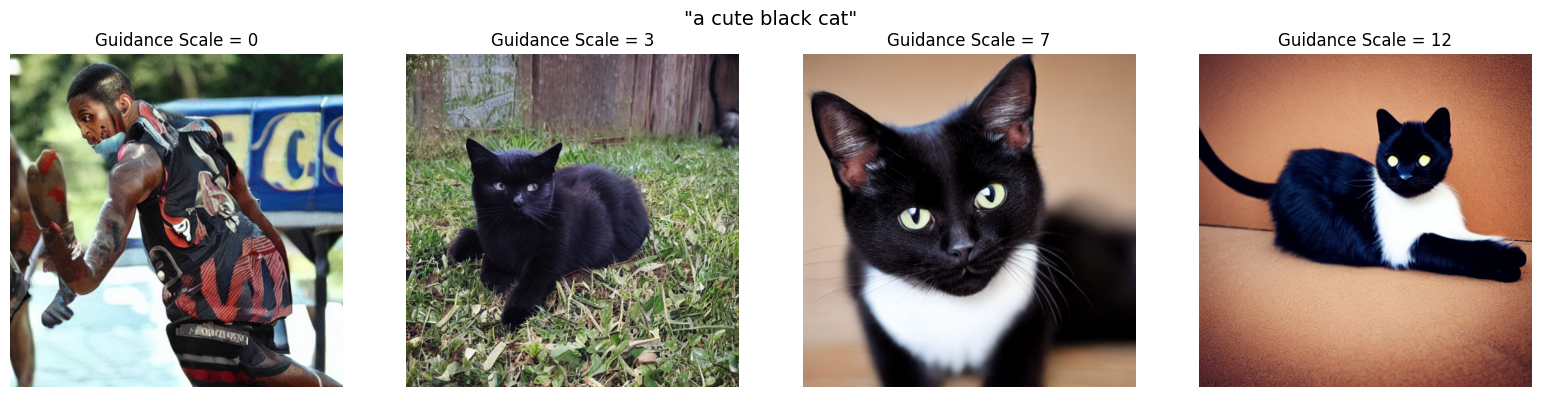

In [8]:
# RUN TO TEST SAMPLE_WITH_GUIDANCE IMPLEMENTATION
# Should expect to see results qualitatively consistent
# with those generated in the previous task using
# the StableDiffusionPipeline

from tqdm import tqdm

# Generate images at different guidance scales

prompt = "a cute black cat"
guidance_scales = [0, 3, 7, 12]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, guidance_scale in enumerate(tqdm(guidance_scales)):
    image = sample_with_guidance(pipe, prompt, guidance_scale=guidance_scale)
    image = image.squeeze(0).permute(1, 2, 0).cpu().detach()
    image = (image + 1) / 2  # Convert from [-1, 1] to [0, 1]
    image = torch.clamp(image, 0, 1)  # Clamp to valid range
    image = image.numpy()

    axes[idx].imshow(image)
    axes[idx].set_title(f'Guidance Scale = {guidance_scale}')
    axes[idx].axis('off')

plt.suptitle(f'"{prompt}"', fontsize=14)
plt.tight_layout()
plt.show()

**Answer the following reflection questions:**

1. **Verify your implementation**: Compare the images generated by your implementation to those from Task 2's `StableDiffusionPipeline`. Are they qualitatively similar? Do they show the same behavior across different guidance scales (e.g., guidance scale 0 ignores the prompt, higher scales produce more prompt-adherent images)? Describe what you observe in 2-4 sentences.

**Answer 1 (TODO):** It appears that the images that were generated by my implementation for Task 4 do look very similar to those images from Task 2's StableDiffusionPipeline since both show similar behavior and pattern when changing the guidance scale. For both, the model tend to mostly ignore the text prompt and would generate random or unrelated images whenever the guidance scale is 0. And the images do match the text prompt more closely when the guidance scale increases. Like when the guidance scale is 3, 7, or 12 for both in Task 4 and Task 2, we can see that the results does clearly show images of a cute black cat.


2. **The role of the VAE**: The VAE in Stable Diffusion serves two purposes: encoding images to latent space during training, and decoding latents to images during generation. In your implementation, you only used the decoder. Why don't we need the encoder during text-to-image generation? In what scenarios would you need to use the encoder?

**Answer 2 (TODO):** I say that we do not need VAE encoder for text-to-image generation in this case because the process starts off with random noise in latent space instead of an existing image. The model here only need to use the VAE decoder to turn that noise into an image that is finalized. The VAE encoder is mainly useful if we have an input image that first needed to be converted into latent space before applying diffusion. So some scenarios where the VAE encoder might be needed would be image-to-image generation, style transfer, or editing existing images to name a few.